# AllLife Bank Customer Segmentation

### Problem Definition & Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. 

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


### Key Questions

- Which variables are most important for clustering?
- How is each cluster different from the others?
- What are the business recommendations?


### Data Description & Dictionary

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Import Pertinent Libraries

In [1]:
!pip install yellowbrick

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

import warnings
warnings.filterwarnings("ignore")

## Inspect Dataset

In [3]:
CC_Cust_Data = pd.read_excel('Credit_Card_Customer_Data.xlsx')   # load dataset

In [4]:
df = CC_Cust_Data.copy()   # copy data to new dataframe to avoid changes to original dataset

In [5]:
df.shape   # confirm shape of dataset

(660, 7)

In [6]:
df.head()   # check first 5 rows

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [7]:
df.tail()   # check last 5 rows

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [8]:
df.sample(n=5, random_state=1)   # view random sample of dataset

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3


In [9]:
# drop 'Sl_No' and 'Customer Key' columns since no analytical value

df.drop("Sl_No", axis=1, inplace=True)   
df.drop("Customer Key", axis=1, inplace=True)

In [10]:
df.info()   # review structure (missing values and feature datatypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [11]:
df.duplicated().sum()   # check for duplicates

11

In [12]:
df.nunique()   # check number of unique values in each column

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [13]:
df.describe().T   # review statistical summary

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


#### Observations
- Avg_Credit_Limit is right-skewed with values ranging from min 3000 to max 200000.
- Total_Credit_Cards ranges from 1 to 10.
- Total_visits_bank ranges from 0 to 5 visits per year.
- Total_Visits_online ranges from 0 to 15 visits per year.
- Total_calls_made ranges from 0 to 10 calls per year.
- No indication of unexplained outliers as data is reasonably within norm. 

## Exploratory Data Analysis

### Univariate Analysis

In [14]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="teal"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

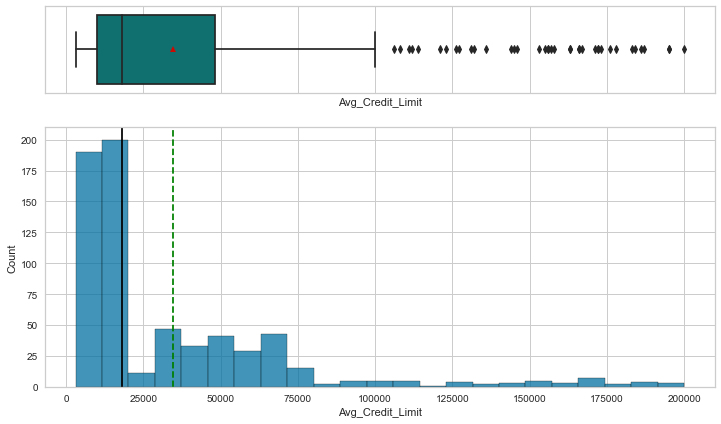

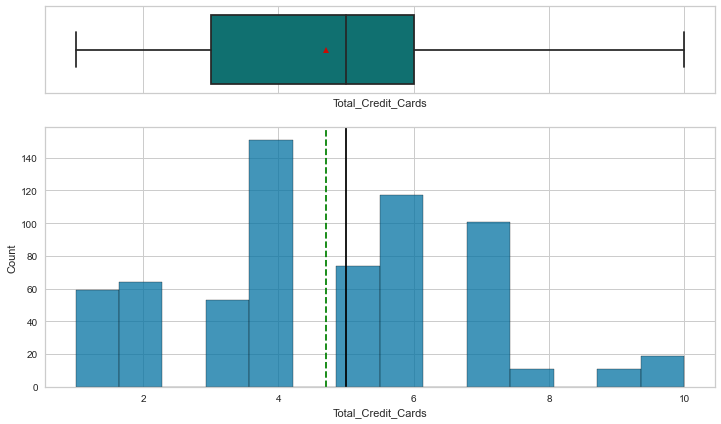

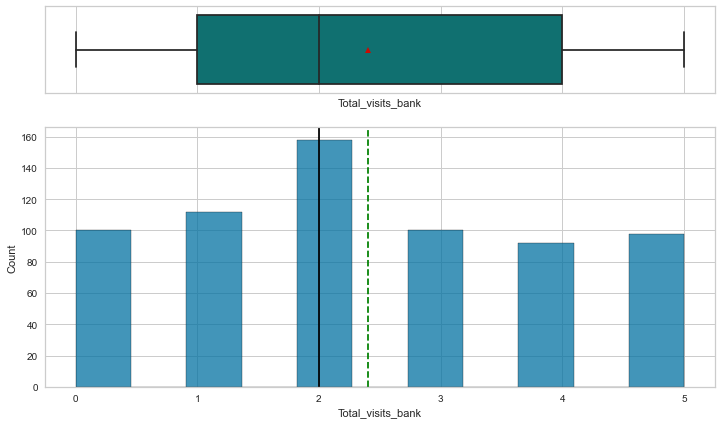

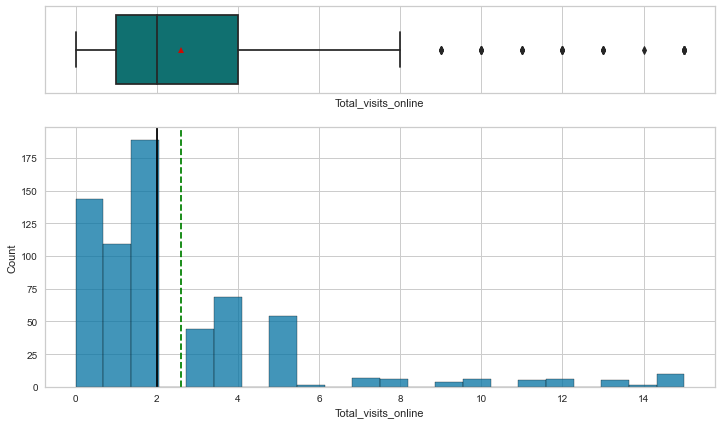

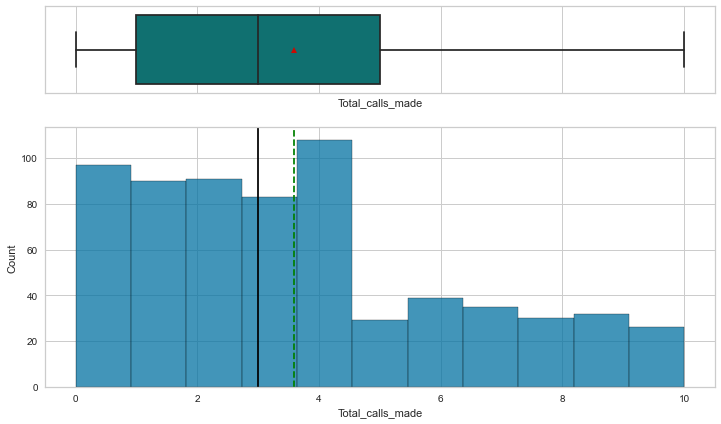

In [15]:
# plot histogram boxplots for all numerical features

for col in df.columns:
    histogram_boxplot(df, col)

#### Observations

- Outliers in Average_Credit_limit and Total_visits_online, however these cannot be discounted because they are within reasonable range and can be meaningful for cluster analysis. 

In [16]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

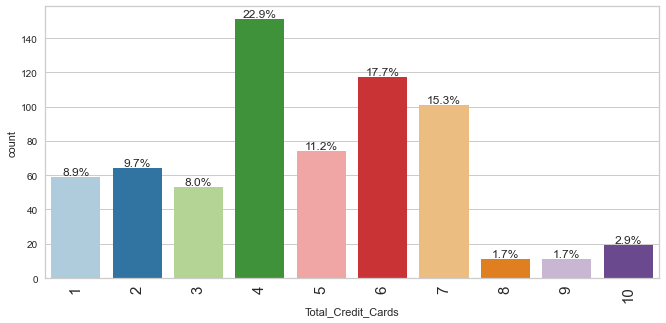

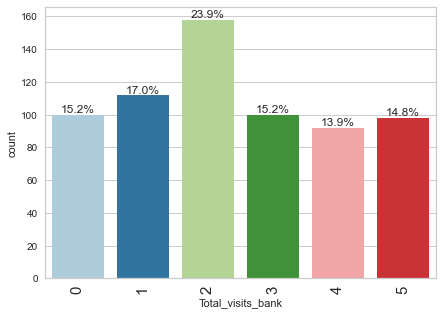

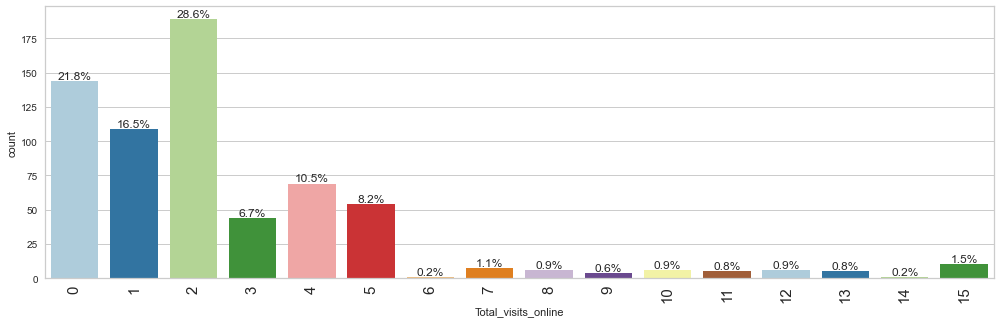

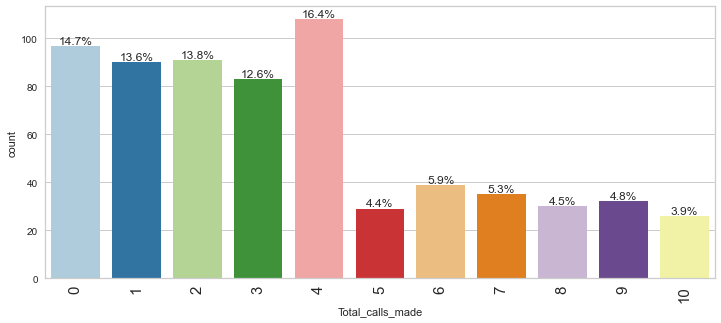

In [17]:
# plot barplots for all numerical features

for col in df.columns.tolist()[1:]:
    labeled_barplot(df, col, perc=True)

#### Observations

- Majority of customers have between 4-7 credit cards; 25% of customers have 3 or fewer credit cards.
- Majority of customers visit in person betwee 1-3 times, while 15% of customers have never visited the bank.
- Majority of customers visit online between 1-5 times, while 22% of customers have never visited online which seems high.
- Majority of customers have made between 1-4 calls, while 15% of customers have never made a call to the bank.

### Bivariate Analysis

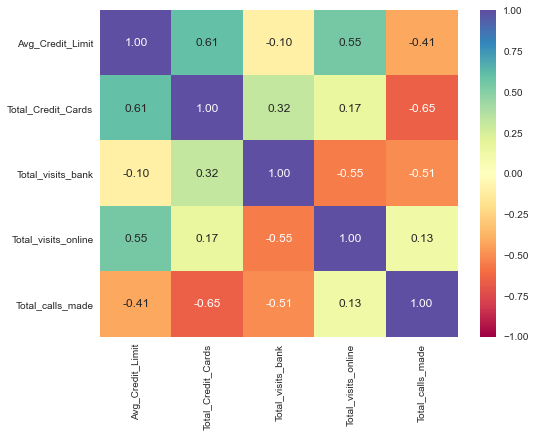

In [18]:
# plot heatmap to check for correlations

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observations

- Strong positive correlation between Total_credit_cards and Avg_credit_limit.
- Strong positive correlation between Total_visits_online and Avg_credit_limit.
- Strong negative correlation between Total_Calls_made and Total_credit_cards.
- Strong negative correlation between Total_visits_online and Total_visits_bank.

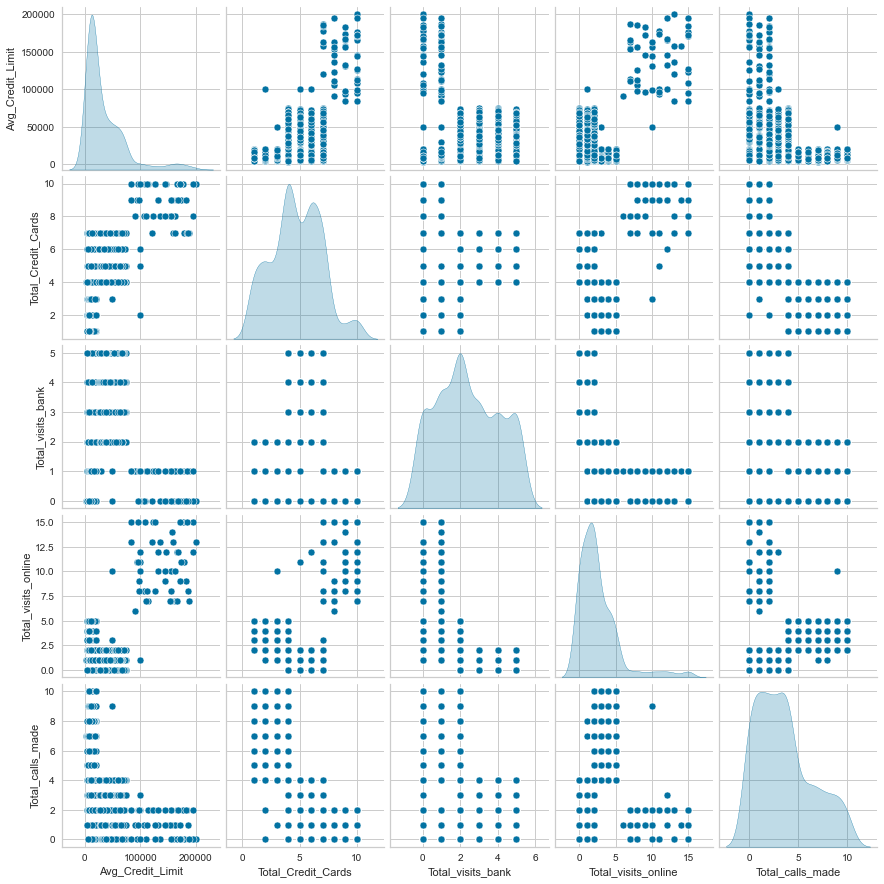

In [19]:
sns.pairplot(data=df, diag_kind="kde")   # check correlation pair plots
plt.show()

## Data Preprocessing

In [20]:
# due to different measurement units, scale the dataset before clustering and create new dataframe.

scaled = df.apply(zscore)
df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## Clustering Methods

### K-Means Clustering

In [21]:
df_kmeans = df_scaled.copy()   # copy scaled dataset

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

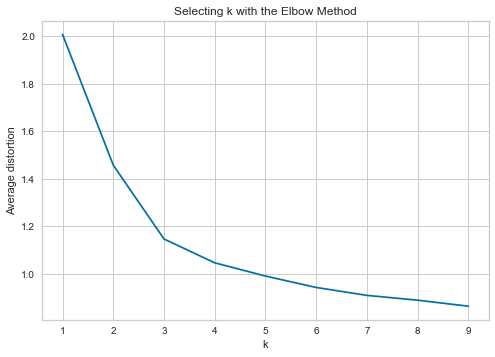

In [22]:
# find optimal number of clusters

from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_kmeans)
    prediction=model.predict(df_kmeans)
    meanDistortions.append(sum(np.min(cdist(df_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / df_kmeans.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.27239829454176767)
For n_clusters = 6, the silhouette score is 0.2559585329098069)
For n_clusters = 7, the silhouette score is 0.24839846123470524)
For n_clusters = 8, the silhouette score is 0.22707766156081427)
For n_clusters = 9, the silhouette score is 0.21904570219965688)
For n_clusters = 10, the silhouette score is 0.2135643891744032)


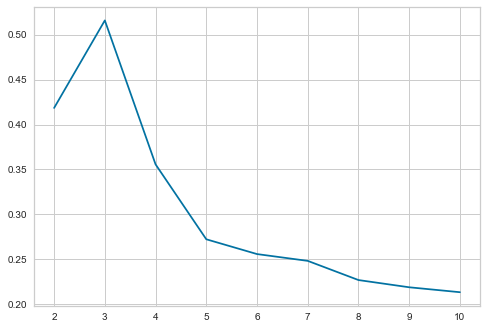

In [23]:
# determine silhouette scores for range of 2-10 clusters

sil_score = []
cluster_list = list(range(2, 11))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_kmeans)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_kmeans, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

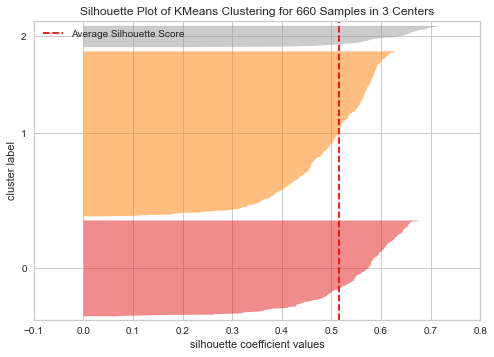

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
# check silhouette visualizer for cluster uniformity

visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_kmeans)
visualizer.show()

#### Observations
- Elbow curve indicates 2-3 clusters.
- Silhouette score is higest for 3 clusters. 
- Silhouette visualizer shows shape of the clusters is uniform.
- Based on the above, lets go ahead with 3 clusters. 

In [25]:
# build k-means model with 3 clusters

kmc_model = KMeans(n_clusters=3, random_state=1)
kmc_model.fit(df_kmeans)
prediction = kmc_model.predict(df_kmeans)

dfk = df.copy()

#Append the prediction 
df_kmeans['KM_Clusters'] = prediction
dfk['KM_Clusters'] = prediction
print("K-Means Clusters Assigned : \n")
dfk.head(10)

K-Means Clusters Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KM_Clusters
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


### Hierarchical Clustering

In [26]:
df_hierarch = df_scaled.copy()   # copy scaled dataset

In [27]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_hierarch, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_hierarch))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875361.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [28]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation

print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


In [29]:
# explore different linkage methods with Euclidean distance only

linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_hierarch, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_hierarch))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [30]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation

print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


#### Observations

- The cophenetic correlation is highest for Euclidean distance and average linkage.


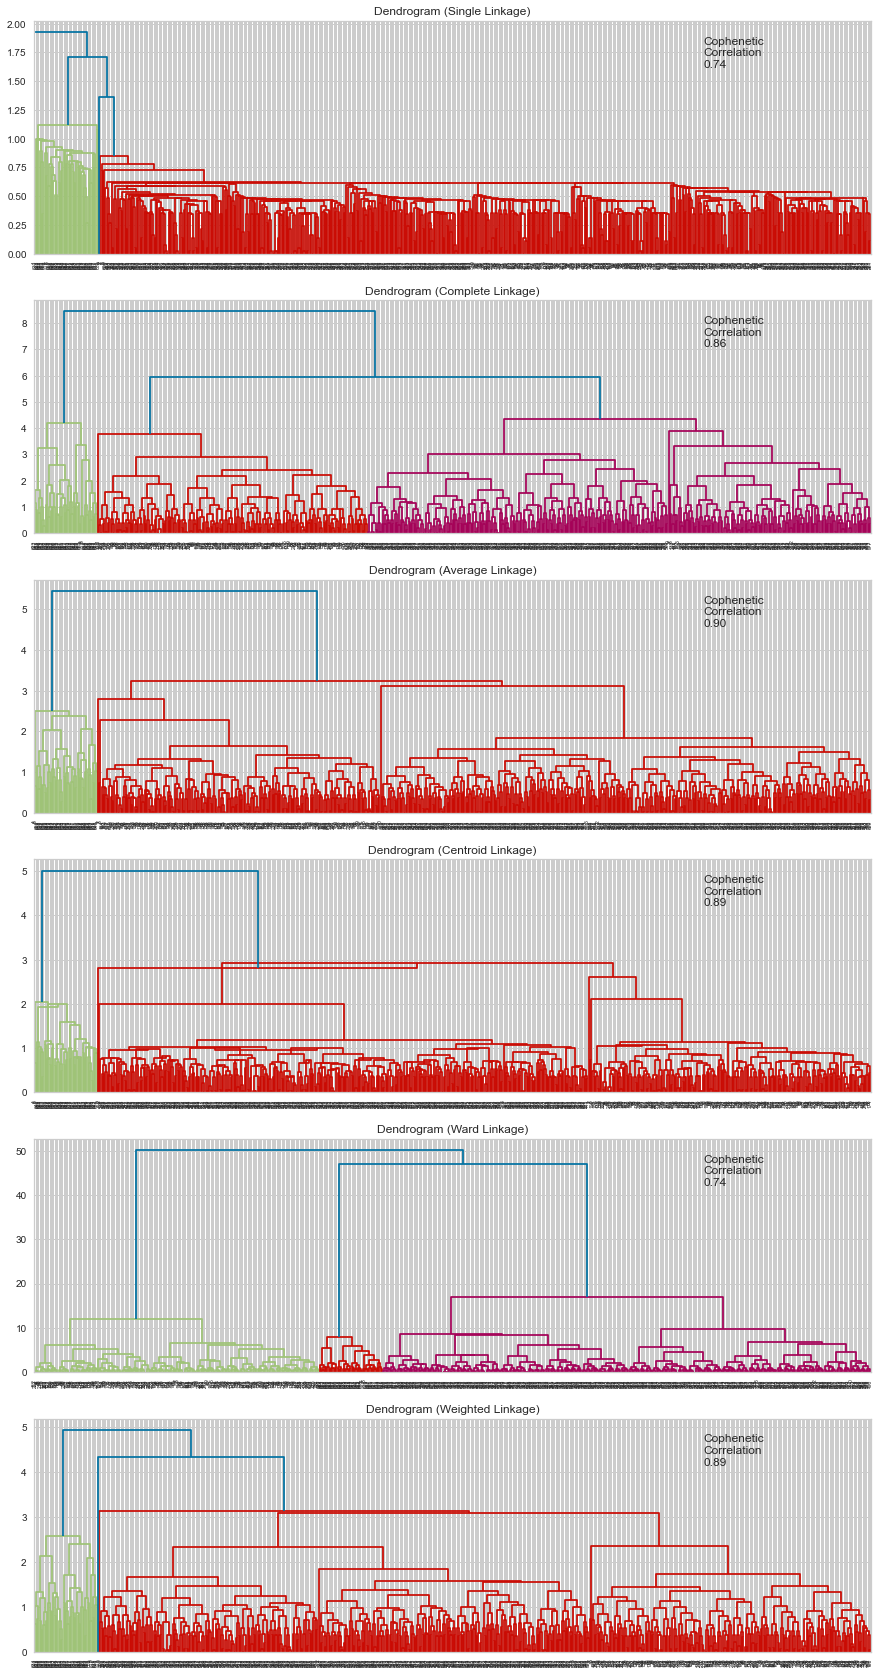

In [31]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_hierarch, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_hierarch))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

#### Observations

- Dendrogram with average linkage shows distinct and separate clusters.

In [32]:
# build hiearchical clustering model with 3 clusters

hac_model = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
hac_model.fit(df_hierarch)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [33]:
# create copy of the original data
dfh = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes

df_hierarch["HA_Clusters"] = hac_model.labels_
dfh["HA_Clusters"] = hac_model.labels_
print("Hierarchical Clusters Assigned : \n")
dfh.head(10)

Hierarchical Clusters Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HA_Clusters
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,2
8,5000,2,0,2,2,2
9,3000,4,0,1,7,2


## Cluster Profiling & Comparison

### K-Means Cluster Profile

In [34]:
df_kmclust = dfk.groupby(['KM_Clusters'])
df_kmclust.count()   # check observation count per cluster

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KM_Clusters,,,,,
0,224,224,224,224,224
1,386,386,386,386,386
2,50,50,50,50,50


In [35]:
df_kmclust.mean().round(2)   # check mean values per cluster

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KM_Clusters,,,,,
0,12174.11,2.41,0.93,3.55,6.87
1,33782.38,5.52,3.49,0.98,2.00
2,141040.00,8.74,0.60,10.90,1.08


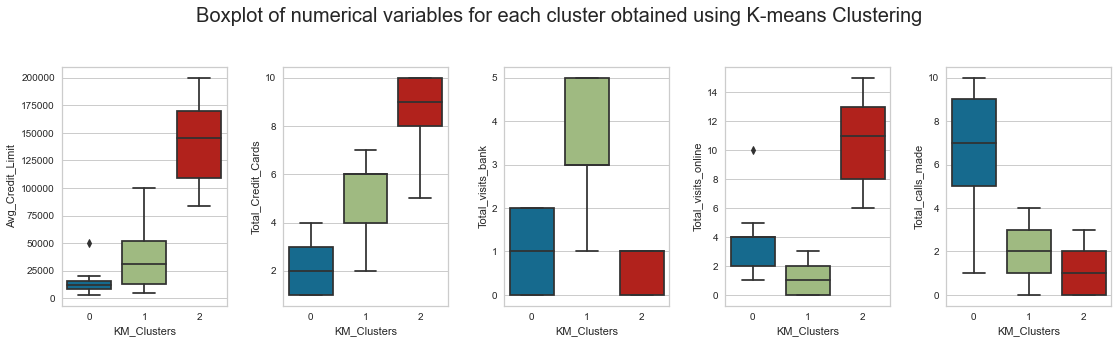

In [36]:
# plot boxplots of numerical variables for each cluster obtained using K-Means Clustering

fig, axes = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using K-means Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df[dfk.columns[counter]], x=df_kmeans["KM_Clusters"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Hierarchical Cluster Profile

In [37]:
df_haclust = dfh.groupby("HA_Clusters")
df_haclust.count()   # check observation count per cluster

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HA_Clusters,,,,,
0,387,387,387,387,387
1,50,50,50,50,50
2,223,223,223,223,223


In [38]:
df_haclust.mean().round(2)   # check mean values per cluster

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HA_Clusters,,,,,
0,33713.18,5.51,3.49,0.98,2.01
1,141040.00,8.74,0.60,10.90,1.08
2,12197.31,2.40,0.93,3.56,6.88


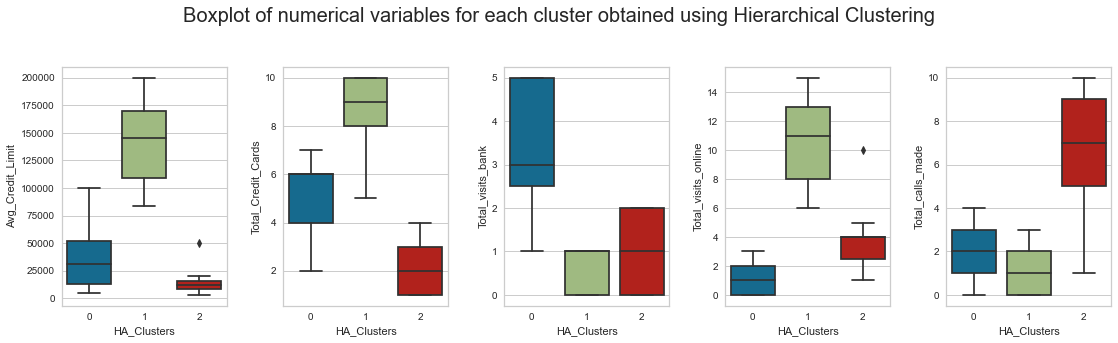

In [39]:
# plot boxplots of numerical variables for each cluster obtained using Hierarchical Clustering

fig, axes = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using Hierarchical Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df[dfh.columns[counter]], x=df_hierarch["HA_Clusters"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Cluster Comparison

#### Observations
- The K-Means and Hierarchical clusters are the same except for the labels, therefore we can analyze either cluster profile. 

Cluster 0:
- Contains 59% of customers.
- Average credit limit ranging from 5000-100000.
- Between total 2-7 credit cards. 
- Between 1-5 total visits to the bank per year. 
- Up to 3 total visits online per year. 
- Up to 4 total service phone calls made per year. 

Cluster 1:
- Contains 7% of customers.
- Average credit limit ranging from 85000-200000.
- Between total 5-10 credit cards. 
- Up to only 1 visit to the bank per year.
- Between 6-15 total visits online per year.
- Up to 3 total service phone calls made per year. 

Cluster 2:
- Contains 34% of customers.
- Customers with average credit limit mostly under 25000 (though one outlier at 50000).
- Between total 1-4 credit cards.
- Up to only 2 visits to the bank per year.
- Between 1-5 total visits online per year.
- Between 1-10 service phone calls per year.

## Conclusion

### Insights
- Cluster 0 customers prefer to visit the bank for their banking needs over visiting online or calling over the phone. This segment is in the middle as far as average credit limit and total credit cards are concerned.
- Cluster 1 customers have the highest credit limits and also the most number of credit cards. This segment prefers online banking, having the least number of bank visits and service phone calls.
- Cluster 2 customers had the lowest credit limits and least number of credit cards. This segment prefers to call over the phone for their banking needs.


### Recommendations
- Cluster 0 customers seem to be traditional in that they prefer to visit the bank in person for their banking needs. It may be worth determining the age group for this segment as there is a high probability that this is a shrinking segment since more and more customers prefer digital banking. It would be advisable to not spend too much on marketing campaigns for this segment.

- Cluster 1 customers are the target segment as they prefer to bank online, have high credit limits and have many credit cards and therefore have the potential to bring in significant revenue. The bank should concentrate on promotions and marketing campaigns for this segment, especially offering more digital features, services and conveniences.

- Cluster 2 customers have the lowest credit limits and fewer credit cards so this is not a high priority segment. But they prefer to bank over the phone, so maybe the bank could invest in building out an effective automated phone solution to cut some overhead costs.